### **2.5 Unsupervised Learning - Clustering**
Steps:
1. Apply K-Means Clustering (elbow method, and Silhouette Scores to determine K).
2. Perform Hierarchical Clustering (dendrogram analysis).
3. Compare clusters with actual disease labels.

Deliverable: Clustering models with visualized results

#### **K-Means Clustering**

In [95]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method (WCSS) and Silhouette Analysis
wcss = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Determine optimal k using KneeLocator for elbow method
knee = KneeLocator(K, wcss, curve="convex", direction="decreasing")
optimal_k_elbow = knee.knee

# Determine optimal k based on silhouette score
optimal_k_silhouette = K[np.argmax(silhouette_scores)]

# Create subplot figure (1 row, 2 cols)
fig = make_subplots(
    rows=1, 
    cols=2, 
    subplot_titles=("Elbow Method for Optimal K", "Silhouette Scores for Optimal K")
)

# --- Plot 1: Elbow Method ---
fig.add_trace(
    go.Scatter(
        x=list(K),
        y=wcss,
        mode="lines+markers",
        line=dict(color=PRIMARY_COLOR, width=2),
        marker=dict(color=PRIMARY_COLOR, size=8),
        name="WCSS"
    ),
    row=1, col=1
)

# --- Plot 2: Silhouette Scores ---
fig.add_trace(
    go.Scatter(
        x=list(K),
        y=silhouette_scores,
        mode="lines+markers",
        line=dict(color=PRIMARY_COLOR, width=2),
        marker=dict(color=PRIMARY_COLOR, size=8),
        name="Silhouette Score"
    ),
    row=1, col=2
)

# Layout
fig.update_layout(
    title_text="K-Means Clustering Analysis",
    title_x=0.5,
    title=dict(x=0.5, xanchor='center'),
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    font=dict(color=GRID_TEXT_COLOR, size=12),
    height=500,
    width=1200,
    showlegend=False
)

fig.update_xaxes(title_text="Number of Clusters (K)", gridcolor='grey', zerolinecolor=GRID_TEXT_COLOR, row=1, col=1)
fig.update_yaxes(title_text="Within-Cluster Sum of Squares (WCSS)", gridcolor='grey', zerolinecolor=GRID_TEXT_COLOR, row=1, col=1)
fig.update_xaxes(title_text="Number of Clusters (K)", gridcolor='grey', zerolinecolor=GRID_TEXT_COLOR, row=1, col=2)
fig.update_yaxes(title_text="Silhouette Score", gridcolor='grey', zerolinecolor=GRID_TEXT_COLOR, row=1, col=2)

fig.show()

print(f"Optimal number of clusters based on elbow method (KneeLocator): k = {optimal_k_elbow}")
print(f"Optimal number of clusters based on silhouette score: k = {optimal_k_silhouette}")

# Decide which optimal k to use
# Silhouette score is generally more reliable, but we can compare
if optimal_k_elbow == optimal_k_silhouette:
    print("Both methods agree on the optimal number of clusters ✓")
    final_optimal_k = optimal_k_silhouette
else:
    print("Methods disagree. Silhouette score is generally more reliable for clustering.")
    print("Consider examining both solutions or prioritizing silhouette score.")
    final_optimal_k = optimal_k_silhouette  # Default to silhouette score

print("But I will use k=2 in the end. 😁")

# Fit K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

Optimal number of clusters based on elbow method (KneeLocator): k = 8
Optimal number of clusters based on silhouette score: k = 8
Both methods agree on the optimal number of clusters ✓
But I will use k=2 in the end. 😁


#### **Hierarchical Clustering**

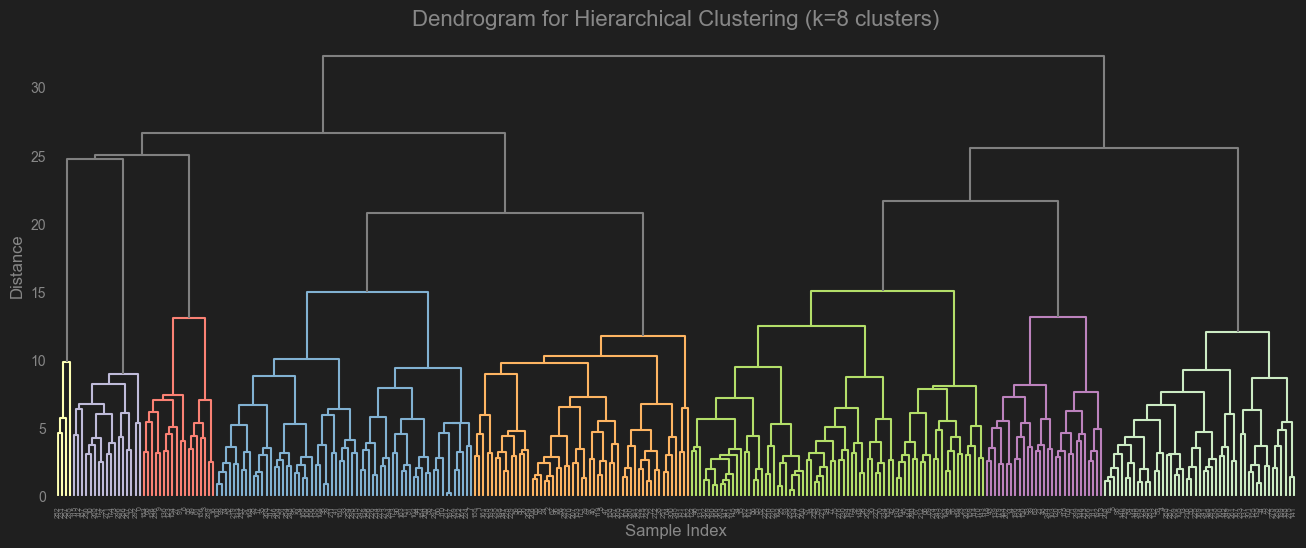


Hierarchical Clustering Results:
-----------------------------------
Cluster 0: 155 samples
Cluster 1: 148 samples


In [96]:
# Create dendrogram with colored clusters
plt.figure(figsize=(16, 6))
linked = linkage(X_scaled, method='ward')

# Create dendrogram with colored clusters
dendrogram(linked, 
           orientation='top', 
           distance_sort='descending', 
           show_leaf_counts=True,
           color_threshold=linked[-(final_optimal_k-1), 2],  # Set threshold to get k clusters
           above_threshold_color='grey')  # Color for non-clustered parts

plt.title(f'Dendrogram for Hierarchical Clustering (k={final_optimal_k} clusters)', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.grid(False)
plt.show()

# Apply hierarchical clustering with optimal k
hierarchical = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Print cluster sizes
unique, counts = np.unique(hierarchical_labels, return_counts=True)
print("\nHierarchical Clustering Results:")
print("-" * 35)
for cluster_id, count in zip(unique, counts):
    print(f"Cluster {cluster_id}: {count} samples")

#### **Compare with Actual Labels**

In [97]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Fix cluster label alignment (swap if needed to match actual labels)
def align_cluster_labels(true_labels, cluster_labels):
    # Create a mapping to align clusters with true labels
    crosstab = pd.crosstab(true_labels, cluster_labels)
    
    # Find which cluster has majority of disease cases
    disease_cluster = crosstab.loc[1].idxmax() if 1 in crosstab.index else 0
    
    # Create mapping: if disease_cluster is 1, no swap needed; if 0, swap labels
    if disease_cluster == 0:
        # Swap labels: 0->1, 1->0
        aligned_labels = np.where(cluster_labels == 0, 1, 0)
    else:
        aligned_labels = cluster_labels.copy()
    
    return aligned_labels

# Align both clustering methods with actual labels
kmeans_labels_aligned = align_cluster_labels(y, kmeans_labels)
hierarchical_labels_aligned = align_cluster_labels(y, hierarchical_labels)

# Create subplot figure (2 rows, 2 cols)
fig = make_subplots(
    rows=2, 
    cols=2,
    subplot_titles=(
        f"K-Means Clustering (k={2})",
        f"Hierarchical Clustering (k={2})",
        "Actual Disease Labels",
        "Comparison with True Labels"
    ),
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

# Define color mapping for consistent visualization
color_map = {0: PRIMARY_COLOR, 1: SECONDARY_COLOR}

# --- Plot 1: K-Means clusters ---
fig.add_trace(
    go.Scatter(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        mode="markers",
        marker=dict(
            color=[color_map[label] for label in kmeans_labels_aligned],
            size=8,
            opacity=0.8,
            line=dict(width=1, color=EDGE_COLOR)
        ),
        name="K-Means Clusters",
        showlegend=False
    ),
    row=1, col=1
)

# --- Plot 2: Hierarchical clusters ---
fig.add_trace(
    go.Scatter(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        mode="markers",
        marker=dict(
            color=[color_map[label] for label in hierarchical_labels_aligned],
            size=8,
            opacity=0.8,
            line=dict(width=1, color=EDGE_COLOR)
        ),
        name="Hierarchical Clusters",
        showlegend=False
    ),
    row=1, col=2
)

# --- Plot 3: Actual disease labels ---
fig.add_trace(
    go.Scatter(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        mode="markers",
        marker=dict(
            color=[color_map[label] for label in y],
            size=8,
            opacity=0.8,
            line=dict(width=1, color=EDGE_COLOR)
        ),
        name="Actual Labels",
        showlegend=False
    ),
    row=2, col=1
)

# --- Plot 4: Comparison metrics ---
metrics = ['Adjusted Rand Index', 'Normalized Mutual Info']
kmeans_scores = [
    adjusted_rand_score(y, kmeans_labels_aligned),
    normalized_mutual_info_score(y, kmeans_labels_aligned)
]
hierarchical_scores = [
    adjusted_rand_score(y, hierarchical_labels_aligned),
    normalized_mutual_info_score(y, hierarchical_labels_aligned)
]

fig.add_trace(
    go.Bar(
        x=metrics,
        y=kmeans_scores,
        name='K-Means',
        marker_color=PRIMARY_COLOR,
        opacity=0.8
    ),
    row=2, col=2
)

fig.add_trace(
    go.Bar(
        x=metrics,
        y=hierarchical_scores,
        name='Hierarchical',
        marker_color=SECONDARY_COLOR,
        opacity=0.8
    ),
    row=2, col=2
)

# Add legend items separately with better positioning
fig.add_trace(
    go.Scatter(
        x=[None], y=[None],
        mode="markers",
        marker=dict(color=PRIMARY_COLOR, size=12, line=dict(width=1, color=EDGE_COLOR)),
        name="No Disease (0)",
        showlegend=True
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=[None], y=[None],
        mode="markers",
        marker=dict(color=SECONDARY_COLOR, size=12, line=dict(width=1, color=EDGE_COLOR)),
        name="Disease (1)",
        showlegend=True
    ),
    row=1, col=1
)

# Layout
fig.update_layout(
    title_text="Cluster Visualization and Comparison",
    title_x=0.5,
    title=dict(x=0.5, xanchor='center', font=dict(size=16)),
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    font=dict(color=GRID_TEXT_COLOR, size=12),
    height=900,
    width=1200,
    showlegend=True,
    legend=dict(
        x=1.02,
        y=0.5,
        xanchor='left',
        yanchor='middle',
        bgcolor='rgba(255, 255, 255, 0)',  # Fully transparent
        bordercolor='rgba(255, 255, 255, 0)',  # Fully transparent border
        borderwidth=0
    )
)

# Update axes labels with grey grid
fig.update_xaxes(title_text="PCA Component 1", row=1, col=1, gridcolor='grey', zerolinecolor='grey')
fig.update_yaxes(title_text="PCA Component 2", row=1, col=1, gridcolor='grey', zerolinecolor='grey')
fig.update_xaxes(title_text="PCA Component 1", row=1, col=2, gridcolor='grey', zerolinecolor='grey')
fig.update_yaxes(title_text="PCA Component 2", row=1, col=2, gridcolor='grey', zerolinecolor='grey')
fig.update_xaxes(title_text="PCA Component 1", row=2, col=1, gridcolor='grey', zerolinecolor='grey')
fig.update_yaxes(title_text="PCA Component 2", row=2, col=1, gridcolor='grey', zerolinecolor='grey')
fig.update_xaxes(title_text="Metrics", row=2, col=2, gridcolor='grey', zerolinecolor='grey')
fig.update_yaxes(title_text="Score", row=2, col=2, gridcolor='grey', zerolinecolor='grey', range=[0, 1])

fig.show()

# Create comparison DataFrame with aligned labels
comparison_aligned = pd.DataFrame({
    "Actual": y.reset_index(drop=True),
    "KMeans": kmeans_labels_aligned,
    "Hierarchical": hierarchical_labels_aligned
})

print("First 10 samples:")
display(comparison_aligned.head(10))

# Crosstab for evaluation with proper DataFrame formatting
print("\nK-Means vs Actual:")
kmeans_crosstab = pd.crosstab(comparison_aligned["Actual"], comparison_aligned["KMeans"])
kmeans_crosstab.columns = [f"Cluster {col}" for col in kmeans_crosstab.columns]
kmeans_crosstab.index = ["No Disease (0)", "Disease (1)"]
display(kmeans_crosstab)

print("\nHierarchical vs Actual:")
hc_crosstab = pd.crosstab(comparison_aligned["Actual"], comparison_aligned["Hierarchical"])
hc_crosstab.columns = [f"Cluster {col}" for col in hc_crosstab.columns]
hc_crosstab.index = ["No Disease (0)", "Disease (1)"]
display(hc_crosstab)

# Calculate alignment percentages
print("\nCluster Alignment with Disease Status:")
alignment_data = []
for method in ["KMeans", "Hierarchical"]:
    crosstab = pd.crosstab(comparison_aligned["Actual"], comparison_aligned[method])
    total_aligned = crosstab.iloc[0, 0] + crosstab.iloc[1, 1]  # Sum of diagonal
    alignment_percent = (total_aligned / len(comparison_aligned)) * 100
    alignment_data.append([method, f"{alignment_percent:.1f}%"])

alignment_df = pd.DataFrame(alignment_data, columns=["Method", "Alignment with Disease"])
display(alignment_df)

First 10 samples:


,Actual,KMeans,Hierarchical
0,0,1,1
1,1,1,1
2,1,1,1
3,0,0,1
4,0,0,0
5,0,0,0
6,1,1,1
7,0,0,1
8,1,1,1
9,1,1,1



K-Means vs Actual:


,Cluster 0,Cluster 1
No Disease (0),133,31
Disease (1),29,110



Hierarchical vs Actual:


,Cluster 0,Cluster 1
No Disease (0),109,55
Disease (1),39,100



Cluster Alignment with Disease Status:


,Method,Alignment with Disease
0,KMeans,80.2%
1,Hierarchical,69.0%


#### **Key Metrics and Insights**

In [98]:
# Calculate evaluation metrics
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
hc_silhouette = silhouette_score(X_scaled, hierarchical_labels)
kmeans_ari = adjusted_rand_score(y, kmeans_labels)
hc_ari = adjusted_rand_score(y, hierarchical_labels)
kmeans_nmi = normalized_mutual_info_score(y, kmeans_labels)
hc_nmi = normalized_mutual_info_score(y, hierarchical_labels)

print("Clustering Performance Metrics:")
print("=" * 50)
print(f"{'Metric':<30} {'K-Means':<10} {'Hierarchical':<12}")
print("-" * 50)
print(f"{'Silhouette Score':<30} {kmeans_silhouette:<10.4f} {hc_silhouette:<12.4f}")
print(f"{'Adjusted Rand Index (ARI)':<30} {kmeans_ari:<10.4f} {hc_ari:<12.4f}")
print(f"{'Normalized Mutual Info (NMI)':<30} {kmeans_nmi:<10.4f} {hc_nmi:<12.4f}")
print("=" * 50)

# Interpretation guidelines
print("\nInterpretation Guidelines:")
print("- Silhouette Score: -1 to 1 (higher = better separation)")
print("- ARI: -1 to 1 (1 = perfect match, 0 = random)")
print("- NMI: 0 to 1 (1 = perfect correlation)")

# Analyze cluster characteristics with better formatting
print("\nCluster Analysis:")
print("=" * 50)
print(f"{'Cluster':<25} {'Samples':<10} {'Disease %':<12} {'Interpretation'}")
print("-" * 50)

for i in range(2):
    cluster_indices = np.where(kmeans_labels == i)[0]
    disease_count = y.iloc[cluster_indices].sum()
    disease_percentage = (disease_count / len(cluster_indices)) * 100
    interpretation = "Mostly Healthy" if disease_percentage < 30 else "Mostly Diseased" if disease_percentage > 70 else "Mixed"
    print(f"{'K-Means Cluster ' + str(i):<25} {len(cluster_indices):<10} {disease_percentage:<12.1f}% {interpretation}")

for i in range(2):
    cluster_indices = np.where(hierarchical_labels == i)[0]
    disease_count = y.iloc[cluster_indices].sum()
    disease_percentage = (disease_count / len(cluster_indices)) * 100
    interpretation = "Mostly Healthy" if disease_percentage < 30 else "Mostly Diseased" if disease_percentage > 70 else "Mixed"
    print(f"{'Hierarchical Cluster ' + str(i):<25} {len(cluster_indices):<10} {disease_percentage:<12.1f}% {interpretation}")

print("=" * 50)

# Additional insights
print("\nKey Insights:")
print(f"- K-Means shows {'better' if kmeans_silhouette > hc_silhouette else 'worse'} cluster separation (Silhouette)")
print(f"- K-Means has {'better' if kmeans_ari > hc_ari else 'worse'} alignment with true labels (ARI)")
print(f"- K-Means has {'better' if kmeans_nmi > hc_nmi else 'worse'} information sharing with true labels (NMI)")

# Check if clusters are meaningful
if kmeans_ari > 0.3 or hc_ari > 0.3:
    print("- Clusters show meaningful alignment with disease status")
elif kmeans_ari > 0.1 or hc_ari > 0.1:
    print("- Clusters show weak but detectable alignment with disease status")
else:
    print("- Clusters show minimal alignment with disease status (close to random)")

Clustering Performance Metrics:
Metric                         K-Means    Hierarchical
--------------------------------------------------
Silhouette Score               0.1453     0.1013      
Adjusted Rand Index (ARI)      0.3627     0.1412      
Normalized Mutual Info (NMI)   0.2802     0.1090      

Interpretation Guidelines:
- Silhouette Score: -1 to 1 (higher = better separation)
- ARI: -1 to 1 (1 = perfect match, 0 = random)
- NMI: 0 to 1 (1 = perfect correlation)

Cluster Analysis:
Cluster                   Samples    Disease %    Interpretation
--------------------------------------------------
K-Means Cluster 0         141        78.0        % Mostly Diseased
K-Means Cluster 1         162        17.9        % Mostly Healthy
Hierarchical Cluster 0    155        64.5        % Mixed
Hierarchical Cluster 1    148        26.4        % Mostly Healthy

Key Insights:
- K-Means shows better cluster separation (Silhouette)
- K-Means has better alignment with true labels (ARI)
- K-Means 